In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

Using TensorFlow backend.


In [0]:
import matplotlib
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

import matplotlib.pyplot as plt
from keras.models import load_model
import imutils


In [0]:
with open('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/trainX.pkl', "rb") as f:
    trainX = pickle.load(f)
with open('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/testX.pkl', "rb") as f:
    testX = pickle.load(f)
with open('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/trainY.pkl', "rb") as f:
    trainY = pickle.load(f)
    
with open('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/testY.pkl', "rb") as f:
    testY = pickle.load(f)
    
with open('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/lb.pkl', "rb") as f:
    lb = pickle.load(f)

In [0]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [8]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)


# initialize the model
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

In [10]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

[INFO] training network...
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
29/29 [==============================] - 6s 206ms/step - loss: 1.2886 - acc: 0.6444 - val_loss: 2.3158 - val_acc: 0.5726
Epoch 2/100
29/29 [==============================] - 3s 97ms/step - loss: 1.1400 - acc: 0.7216 - val_loss: 1.2857 - val_acc: 0.7821
Epoch 3/100
29/29 [==============================] - 3s 103ms/step - loss: 0.6673 - acc: 0.8058 - val_loss: 1.0209 - val_acc: 0.7137
Epoch 4/100
29/29 [==============================] - 3s 106ms/step - loss: 0.6908 - acc: 0.7881 - val_loss: 1.4489 - val_acc: 0.7222
Epoch 5/100
29/29 [==============================] - 3s 105ms/step - loss: 0.6906 - acc: 0.8035 - val_loss: 1.2679 - val_acc: 0.6923
Epoch 6/100
29/29 [==============================] - 3s 106ms/step - loss: 0.6399 - acc: 0.8280 - val_loss: 0.6025 - val_acc: 0.8504
Epoch 7/100
29/29 [==============================] - 3s 105ms/step - loss: 0.5278 - acc: 0.8380 - val_loss: 0.7857 - val_acc: 0.

In [11]:
# save the model to disk
print("[INFO] serializing network...")
model.save('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/pokedex_plk.model')

[INFO] serializing network...


In [12]:
# load the trained convolutional neural network and the label
# binarizer
print("[INFO] loading network...")
model = load_model('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/pokedex_plk.model')
lb = pickle.loads(open('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/lb.pkl', "rb").read())




def test(image):
  output = image.copy()

  # pre-process the image for classification
  image = cv2.resize(image, (96, 96))
  image = image.astype("float") / 255.0
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)



  # classify the input image
  print("[INFO] classifying image...")
  proba = model.predict(image)[0]
  idx = np.argmax(proba)
  label = lb.classes_[idx]

  # we'll mark our prediction as "correct" of the input image filename
  # contains the predicted label text (obviously this makes the
  # assumption that you have named your testing image files this way)
  filename = image_path[image_path.rfind(os.path.sep) + 1:]
  correct = "correct" if filename.rfind(label) != -1 else "incorrect"

  print(filename)
  # build the label and draw the label on the image
  label = "{}: {:.2f}% ({})".format(label, proba[idx] * 100, correct)
  output = imutils.resize(output, width=400)
  cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (0, 255, 0), 2)

  # show the output image
  print("[INFO] {}".format(label))

  plt.imshow(output)

[INFO] loading network...


[INFO] classifying image...
charmander_counter.png
[INFO] charmander: 90.69% (correct)


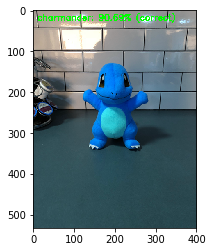

In [13]:
# load the image
image_path = '/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/examples/charmander_counter.png'
image = cv2.imread(image_path)

test(image)

[INFO] classifying image...
bulbasaur_plush.png
[INFO] bulbasaur: 98.26% (correct)


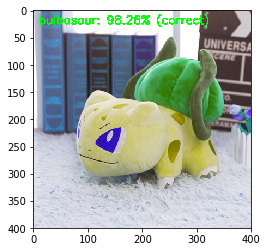

In [14]:
# load the image
image_path = '/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/examples/bulbasaur_plush.png'
image = cv2.imread(image_path)

test(image)

[INFO] classifying image...
mewtwo_toy.png
[INFO] mewtwo: 99.96% (correct)


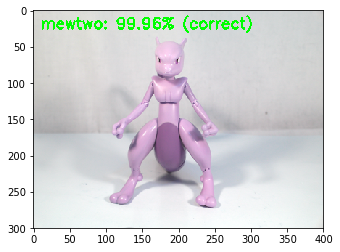

In [15]:
# load the image
image_path = '/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/examples/mewtwo_toy.png'
image = cv2.imread(image_path)

test(image)

[INFO] classifying image...
pikachu_toy.png
[INFO] pikachu: 100.00% (correct)


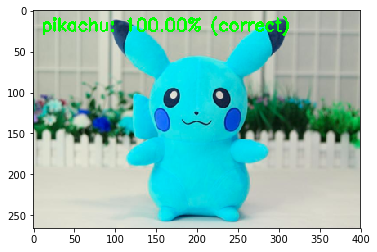

In [16]:
# load the image
image_path = '/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/examples/pikachu_toy.png'
image = cv2.imread(image_path)

test(image)

[INFO] classifying image...
squirtle_plush.png
[INFO] squirtle: 86.86% (correct)


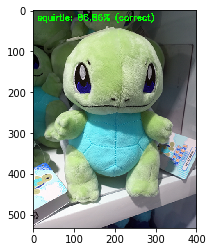

In [17]:
# load the image
image_path = '/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/examples/squirtle_plush.png'
image = cv2.imread(image_path)

test(image)

[INFO] classifying image...
charmander_hidden.png
[INFO] charmander: 70.11% (correct)


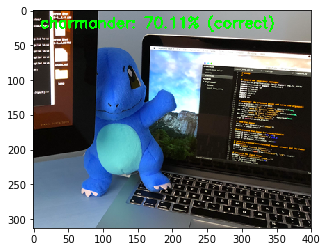

In [18]:
# load the image
image_path = '/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/examples/charmander_hidden.png'
image = cv2.imread(image_path)

test(image)